Usefull stuff:

script to clean IMDB reviews and do sentiment analysis
https://github.com/jaypatel00174/moviesentiment_analysis/blob/master/sentiment.py

Hands-On Recommendation Systems with Python
https://www.amazon.com/Hands-Recommendation-Systems-Python-recommendation/dp/1788993756/ref=sr_1_fkmrnull_6?ajr=2&crid=19F7GJ0JYV2AD&keywords=hands-on+recommendation+systems+with+python&linkCode=sl2&linkId=96a355cac564ae8ae2ea24bee599beb7&qid=1547756269&sprefix=hands+on+recommenda%2Caps%2C559&sr=8-6-fkmrnull&tag=tutorialedge-20

ncie script to download movie data from cli
https://github.com/prateekkalra/movie-py-cli/blob/master/movie-py.py

ml on movie ratings
https://www.kaggle.com/juanjotwo/deep-learning-with-python-notebooks-3-5-imdb

the Kaggle site with 1000+ kernels
https://www.kaggle.com/tmdb/tmdb-movie-metadata



### Build a recommender system on IMDB 

https://www.kaggle.com/fabiendaniel/film-recommendation-engine

https://www.kaggle.com/fabiendaniel/categorizing-actors-hands-on-plotly

In [164]:
%matplotlib inline
import pandas as pd
import numpy as np
import json
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import math, nltk, warnings
from nltk.corpus import wordnet
from sklearn import linear_model
from sklearn.neighbors import NearestNeighbors

pd.set_option('display.max_columns', 100)

PATH = 'data/'
FILE_CREDITS = 'tmdb_5000_credits.csv'
FILE_MOVIES = 'tmdb_5000_movies.csv'

#nltk.download('wordnet')

In [162]:
def reduce_mem_usage(df, verbose=True):
    """
    Found on https://www.kaggle.com/fabiendaniel/elo-world
    Look up machine limits for integer types
    If the column dtype > the smallest integer expressible by the type and 
    column type < the largest integer expressible by the type, replace
    Idem for floating point types.
    Docs and examples:
     https://www.dataquest.io/blog/pandas-big-data/
    """
    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    start_mem = df.memory_usage().sum() / 1024**2    
    for col in df.columns:
        col_type = df[col].dtypes
        if col_type in numerics:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)    
    end_mem = df.memory_usage().sum() / 1024**2
    if verbose: print('Mem. usage decreased to {:5.2f} Mb ({:.1f}% reduction)'\
                      .format(end_mem, 100 * (start_mem - end_mem) / start_mem))
    return df

In [163]:
movies = reduce_mem_usage(movies)

Mem. usage decreased to  0.67 Mb (0.0% reduction)


In [5]:
def pipe_names(keywords):
    return '|'.join([x['name'] for x in keywords])

def label_decade(s):
    val = (1900 + s, s)[s < 100]
    decade = '' if s < 50 else "{}'s".format(int(val))
    return decade

def read_movies(file):
    df = pd.read_csv(file)
    
    # date to Dutch format
    df['release_date'] = (df['release_date']
                          .apply(lambda x: pd.to_datetime(x, format = '%Y-%m-%d')))
    df['release_year'] = df['release_date'].dt.year  
    df['release_year'] = (df['release_year'].astype(float).fillna(0)
                          .map('{:.0f}'.format).astype(int))
    df['release_decade'] = (df['release_year'].apply(lambda x:((x-1900)//10)*10)
                           .apply(label_decade))
    df['release_date'] = df['release_date'].dt.strftime('%d-%m-%Y')
    
    json_columns = ['genres', 'keywords', 'production_countries',
                        'production_companies', 'spoken_languages']
    # to unquote, remove string
    for col in json_columns:
        df[col] = df[col].apply(json.loads)
        
    # unnest dict_lists and rename columns
    df['genre_name'] = df['genres'].apply(pipe_names)
    df['genre_id'] = df['genres'].apply(lambda x: [d.get('id') for d in x])
    df['keywords'] = df['keywords'].apply(pipe_names)
    df['prod_co_name'] = df['production_companies'].apply(lambda x: [d.get('name') for d in x])
    df['prod_co_id'] = df['production_companies'].apply(lambda x: [d.get('id') for d in x])
    df['language'] = (df['spoken_languages']
                      .apply(lambda x: [d.get('iso_639_1') for d in x]))
    df['prod_countries'] = (df['production_countries']
                            .apply(lambda x: [d.get('iso_3166_1') for d in x]))
    
    drop_cols = ['production_companies', 'spoken_languages', 'production_countries', 
                 'genres', 'homepage']
    for col in drop_cols:
        df = df.drop(col, axis=1)
 
    return df   


In [6]:
movies = read_movies(PATH + FILE_MOVIES)

In [7]:
def access(container, index_values):
    # return NaN rather than an error upon indexing/key failure
    result = container
    try:
        for idx in index_values:
            result = result[idx]
        return result
    except IndexError or KeyError:
        return np.nan

def get_director(crew_data):
    directors = [x['name'] for x in crew_data if x['job'] == 'Director']
    return access(directors, [0])


def read_credits(file):
    df = pd.read_csv(file)
    json_columns = ['cast', 'crew']
    for column in json_columns:
        df[column] = df[column].apply(json.loads)
    
    df['actor_1_name'] = df['cast'].apply(lambda x: access(x, [1, 'name']))
    df['actor_2_name'] = df['cast'].apply(lambda x: access(x, [2, 'name']))
    df['actor_3_name'] = df['cast'].apply(lambda x: access(x, [3, 'name']))
    df['director'] = df['crew'].apply(get_director)
    
    return df

In [8]:
df_cred = read_credits(PATH + FILE_CREDITS)

### exploring keywords

To develop a recommendation engine we make extensive use of the keywords that describe the films. Basic assumption is that films described by similar keywords should have similar content. Hence, the way keywords are defined is a 1st step.

In [9]:
# list the keywords which are in the dataset
movies['keywords'][0]

'culture clash|future|space war|space colony|society|space travel|futuristic|romance|space|alien|tribe|alien planet|cgi|marine|soldier|battle|love affair|anti war|power relations|mind and soul|3d'

In [10]:
# create unique set of keywords
set_kw = set()

for kw in movies['keywords'].str.split('|').values:
    if isinstance(kw, float): continue
    set_kw = set_kw.union(kw)
set_kw.remove('')

In [11]:
def count_word(df, ref_col, kw_set):
    """
    count key word occurences in pd series
    Args:
     df : Pandas DF
     ref_col: Series containing piped keywords
     kw_set : reference unique keyword set
    """
    kw_count = {}
    for s in kw_set: kw_count[s] = 0
    for kws in df[ref_col].str.split('|'):        
        if type(kws) == float and pd.isnull(kws): continue        
        for s in [s for s in kws if s in kw_set]: 
            if pd.notnull(s): kw_count[s] += 1
    
    # convert dict --> list and sort kw frequency
    kw_occurences = []
    for k,v in kw_count.items():
        kw_occurences.append([k,v])
    kw_occurences.sort(key = lambda x:x[1], reverse = True)
        
    return kw_occurences, kw_count

In [12]:
kw_occurences, kw_count = count_word(df = movies, ref_col='keywords', kw_set=set_kw)

In [ ]:
### grouping by roots

In [30]:
def keywords_inventory(df, ref_col = 'keywords'):
    
    PS = nltk.stem.PorterStemmer()
    
    kw_roots  = dict()  # collect the words / root
    kw_select = dict()  # association: root <-> keyword
    category_keys = []
    
    icount = 0
    for s in df[ref_col]:
        if pd.isnull(s): continue
        for t in s.split('|'):
            t = t.lower() ; root = PS.stem(t)
            if root in kw_roots:                
                kw_roots[root].add(t)
            else:
                kw_roots[root] = {t}
    
    for s in kw_roots.keys():
        if len(kw_roots[s]) > 1:  
            min_length = 1000
            for k in kw_roots[s]:
                if len(k) < min_length:
                    clef = k ; min_length = len(k)            
            category_keys.append(clef)
            kw_select[s] = clef
        else:
            category_keys.append(list(kw_roots[s])[0])
            kw_select[s] = list(kw_roots[s])[0]
                   
    print("Nb of keywords in variable '{}': {}".format(ref_col,len(category_keys)))
    
    return category_keys, kw_roots, kw_select

In [31]:
keywords, keywords_roots, keywords_select = keywords_inventory(movies, 'keywords')

Nb of keywords in variable 'keywords': 9474


In [32]:
# Replacement of the keywords by the main form
def remplacement_df_keywords(df, dico_remplacement, roots = False):
    df_new = df.copy(deep = True)
    for index, row in df_new.iterrows():
        chaine = row['keywords']
        if pd.isnull(chaine): continue
        nouvelle_liste = []
        for s in chaine.split('|'): 
            clef = PS.stem(s) if roots else s
            if clef in dico_remplacement.keys():
                nouvelle_liste.append(dico_remplacement[clef])
            else:
                nouvelle_liste.append(s)       
        df_new.set_value(index, 'keywords', '|'.join(nouvelle_liste)) 
    return df_new

In [34]:
PS = nltk.stem.PorterStemmer()
df_keywords_cleaned = remplacement_df_keywords(movies, keywords_select,
                                               roots = True)

/home/diederik/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:15: FutureWarning: set_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  from ipykernel import kernelapp as app


In [82]:
#keywords.remove('')
keyword_occurences, keywords_count = count_word(df_keywords_cleaned,'keywords',keywords)
keyword_occurences[:5]

[['woman director', 324],
 ['independent film', 318],
 ['duringcreditsstinger', 307],
 ['based on novel', 197],
 ['murder', 197]]

### Groups of synonyms

clean the list of keywords in 2 steps. As a first step, suppress the keywords that appear less that 5 times and replace them by a synomym of higher frequency. As a second step, I suppress all the keywords that appear in less than 3 films.

In [70]:
def get_synonymes(mot_cle):
    lemma = set()
    for ss in wordnet.synsets(mot_cle):
        for w in ss.lemma_names():
            # We just get the 'nouns':
            index = ss.name().find('.')+1
            if ss.name()[index] == 'n': lemma.add(w.lower().replace('_',' '))
    return lemma   

In [48]:
mot_cle = 'romance'
lemma = get_synonymes(mot_cle)
for s in lemma:
    print(' "{:<30}" in keywords list -> {} {}'\
          .format(s, s in keywords, 
                  keywords_count[s] if s in keywords else 0 ))

 "love story                    " in keywords list -> True 1
 "love affair                   " in keywords list -> True 3
 "romance                       " in keywords list -> True 23
 "romanticism                   " in keywords list -> False 0
 "romance language              " in keywords list -> False 0
 "latinian language             " in keywords list -> False 0


In [91]:
word_replacer

{'abortion': 'miscarriage',
 'abuse': 'insult',
 'adrenalin': 'epinephrine',
 'air': 'aviation',
 'alarm': 'alarm clock',
 'allies': 'friend',
 'als': 'alabama',
 'amphetamine': 'speed',
 'amulet': 'talisman',
 'anarchy': 'lawlessness',
 'apparition': 'shadow',
 'appeal': 'prayer',
 'approach': 'attack',
 'arabian': 'arab',
 'archeologist': 'archaeologist',
 'ark': 'ark of the covenant',
 'arms': 'weapon',
 'artillery': 'gun',
 'artwork': 'art',
 'assurance': 'pledge',
 'audience': 'interview',
 'automaton': 'zombie',
 'autumn': 'fall',
 'avant-garde': 'van',
 'axe': 'ax',
 'babes': 'baby',
 'baghdad': 'bagdad',
 'balance': 'correspondence',
 'ball': 'egg',
 'band': 'ring',
 'bankruptcy': 'failure',
 'barbarian': 'peasant',
 'base': 'home',
 'bath': 'bathtub',
 'bathroom': 'bath',
 'beast': 'wolf',
 'beef': 'bitch',
 'bias': 'prejudice',
 'bitterness': 'resentment',
 'blackout': 'amnesia',
 'blade': 'sword',
 'blast': 'fire',
 'bloodshed': 'gore',
 'bloodsucker': 'leech',
 'bodybuilder

In [113]:
keyword_occurences.sort(key = lambda x:x[1], reverse = False)

key_count = dict()
for s in keyword_occurences:
    key_count[s[0]] = s[1]

# Creation of a dictionary to replace keywords by higher frequency keywords
word_replacer = dict()
icount = 0
for index, [word, occurences] in enumerate(keyword_occurences):
    if occurences > 5: continue  # only keywords appearing < 5x
    lemma = get_synonymes(word)
    if len(lemma) == 0: continue   
   
    word_list = [(s, key_count[s]) for s in lemma 
                  if test_keyword(s, key_count, key_count[word])]
    word_list.sort(key = lambda x:(x[1],x[0]), reverse = True)    

    if len(word_list) <= 1: continue       # no replacement
    if word == word_list[0][0]: continue    # replacement by himself
    
    icount += 1
    if  icount < 8:
        print('{:<12} -> {:<12} (init: {})'.format(word, word_list[0][0], word_list))    
    word_replacer[word] = word_list[0][0]

print(90*'_'+'\n'+'word_replacer replaced {}% of keywords.'
      .format(round(len(word_replacer)/len(keywords)*100,2)))

narcism      -> narcissism   (init: [('narcissism', 1), ('narcism', 1)])
apparition   -> shadow       (init: [('shadow', 3), ('phantom', 3), ('apparition', 1)])
macao        -> macau        (init: [('macau', 1), ('macao', 1)])
regent       -> trustee      (init: [('trustee', 1), ('regent', 1)])
civilization -> culture      (init: [('culture', 2), ('civilization', 1)])
ark          -> ark of the covenant (init: [('ark of the covenant', 2), ('ark', 1)])
automaton    -> zombie       (init: [('zombie', 45), ('robot', 27), ('automaton', 1)])
__________________________________________________________________________________________
word_replacer replaced 5.96% of keywords.


In [114]:
# 2 successive replacements
print('Keywords that appear both in keys and values:'.upper()+'\n'+45*'-')
icount = 0
for s in word_replacer.values():
    if s in word_replacer.keys():
        icount += 1
        if icount < 10: print('{:<20} -> {:<20}'.format(s, word_replacer[s]))

for key, value in word_replacer.items():
    if value in word_replacer.keys():
        word_replacer[key] = word_replacer[value] 

KEYWORDS THAT APPEAR BOTH IN KEYS AND VALUES:
---------------------------------------------
shadow               -> dark                
failure              -> loser               
leech                -> parasite            
carnival             -> circus              
pit                  -> hell                
drawing              -> lottery             
deal                 -> mountain            
twist                -> crook               
pest                 -> plague              


### replace the keywords 

keywords that appeared < 5 times are replaced by a synomym of higher frequency. Also keywords that appear in less than 3 films are removed.

In [121]:
df_keywords_synonyms = \
            remplacement_df_keywords(df_keywords_cleaned, word_replacer, roots = False)   
keywords, keywords_roots, keywords_select = \
            keywords_inventory(df_keywords_synonyms, ref_col= 'keywords')

/home/diederik/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:15: FutureWarning: set_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  from ipykernel import kernelapp as app


Nb of keywords in variable 'keywords': 8910


In [122]:
keywords.remove('')
new_keyword_occurences, keywords_count = count_word(df_keywords_synonyms,
                                                    'keywords',keywords)
new_keyword_occurences[:5]

[['woman director', 324],
 ['independent film', 318],
 ['duringcreditsstinger', 307],
 ['based on novel', 197],
 ['murder', 197]]

In [139]:
# deletion of keywords with low frequencies
#-------------------------------------------
def remplacement_df_low_frequency_keywords(df, keyword_occurences):
    df_new = df.copy(deep = True)
    key_count = dict()
    for s in keyword_occurences: 
        key_count[s[0]] = s[1]    
    for index, row in df_new.iterrows():
        chaine = row['keywords']
        if pd.isnull(chaine): continue
        nouvelle_liste = []
        for s in chaine.split('|'): 
            if key_count.get(s, 4) > 3: nouvelle_liste.append(s)
        df_new.set_value(index, 'keywords', '|'.join(nouvelle_liste))
    return df_new

In [140]:
# Creation of a dataframe where keywords of low frequencies are suppressed
df_keywords_occurence = \
    remplacement_df_low_frequency_keywords(df_keywords_synonyms, new_keyword_occurences)
keywords, keywords_roots, keywords_select = \
    keywords_inventory(df_keywords_occurence, ref_col= 'keywords')   

/home/diederik/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: set_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  


Nb of keywords in variable 'keywords': 2121


In [142]:
# New keywords count
#-------------------
keywords.remove('')
new_keyword_occurences, keywords_count = count_word(df_keywords_occurence,
                                                    'keywords',keywords)
new_keyword_occurences[:5]

[['woman director', 324],
 ['independent film', 318],
 ['duringcreditsstinger', 307],
 ['based on novel', 197],
 ['murder', 197]]

/home/diederik/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1331: UserWarning: findfont: Font family ['DejaVu'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
/home/diederik/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1331: UserWarning: findfont: Font family ['fantasy'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


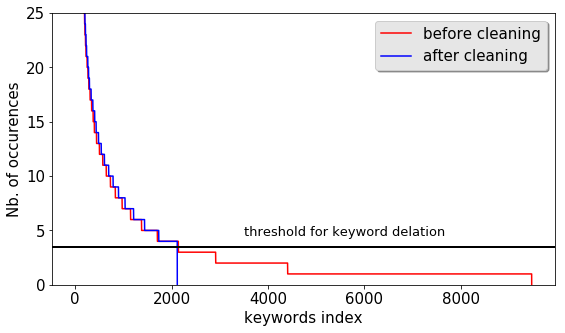

In [144]:
# Graph of keyword occurences
#----------------------------
font = {'family' : 'DejaVu', 'weight' : 'normal', 'size'   : 15}
mpl.rc('font', **font)

keyword_occurences.sort(key = lambda x:x[1], reverse = True)

y_axis = [i[1] for i in keyword_occurences]
x_axis = [k for k,i in enumerate(keyword_occurences)]

new_y_axis = [i[1] for i in new_keyword_occurences]
new_x_axis = [k for k,i in enumerate(new_keyword_occurences)]

f, ax = plt.subplots(figsize=(9, 5))
ax.plot(x_axis, y_axis, 'r-', label='before cleaning')
ax.plot(new_x_axis, new_y_axis, 'b-', label='after cleaning')

# Now add the legend with some customizations.
legend = ax.legend(loc='upper right', shadow=True)
frame = legend.get_frame()
frame.set_facecolor('0.90')
for label in legend.get_texts():
    label.set_fontsize('medium')
            
plt.ylim((0,25))
plt.axhline(y=3.5, linewidth=2, color = 'k')
plt.xlabel("keywords index", family='fantasy', fontsize = 15)
plt.ylabel("Nb. of occurences", family='fantasy', fontsize = 15)
#plt.suptitle("Nombre d'occurences des mots clés", fontsize = 18, family='fantasy')
plt.text(3500, 4.5, 'threshold for keyword delation', fontsize = 13)
plt.show()